## 原始惑星円盤「分子輝線イメージよりガス円盤の回転を調べる」

今回使用するデータは、ALMAで観測された原始惑星系円盤を持つ「HL Tau」のH<sub>2</sub>CO分子輝線キューブイメージデータです。<br>
ALMA Science Archiveより、以下を検索してください。<br>
- Project code: 2018.1.01037.S<br>
- Source Name: HL_Tau<br>

JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information :
    https://jvo.nao.ac.jp/portal/alma/archive.do?action=dataset.info&datasetId=ALMA01424659 <br>
- FITS link :
    http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01424659_00_00_00

### モジュールの読み込み（インストール）

最初に、Google Colab環境の場合、CASAモジュールをインストールしてCASA実行環境を構築する処理を行っています。

In [1]:
import sys, os
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [2]:
# For Google Colaboratory（Google Colab環境か判別し、Google Colab環境ならCASA実行環境を構築）
print(type(sys.modules))
moduleList = sys.modules
ENV_COLAB = False

if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")

if ENV_COLAB:
    print("Execute in google_colab")
#    print("installing pre-requisite packages...\n")

    print("installing casa packages...\n")
    !pip install casatools==6.6.0.20 # should install version 6.6.0 or later for Google Colab (python 3.10)
    !pip install casatasks==6.6.0.20
#    !pip install casatools
#    !pip install casatasks
    !pip install casadata

    print("make a config file for Google Colab...\n")
    !mkdir ~/.casa
    !echo "home     = '/content/'" > ~/.casa/config.py
    !echo "datapath = ['`find / -type d -name casadata`']" >> ~/.casa/config.py
    !more ~/.casa/config.py
    print("Completion of CASA preparation")

<class 'dict'>
google_colab
Execute in google_colab
installing casa packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 MB 3.2 MB/s eta 0:00:00
make a config file for Google Colab...

find: ‘/proc/63/task/63/net’: Invalid argument
find: ‘/proc/63/net’: Invalid argument
home     = '/content/'
datapath = ['/usr/local/lib/python3.10/dist-packages/casadata']
Completion of CASA preparation


In [3]:
import casatools
import casatasks

以下では必要なモジュールを読み込んでいます。<br>
ローカル環境で実行する場合は、以下で読み込んでいるモジュール及びCASAモジュールをあらかじめインストールしてから実行して下さい。

In [4]:
#import sys, os
import math
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

### JVOよりイメージFITSデータのダウンロード

In [5]:
# line cube image data
url = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01424659_00_00_00'
orgimfits='ALMA01424659_00_00_00.fits'
myimages ='HL_Tau.H2CO.cube'
# continuum image data
url2 = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01424653_00_00_00'
orgimfits2='ALMA01424653_00_00_00.fits'
myimages2 ='HL_Tau.cont'

url/orgimfitsではダウンロードするイメージFITSのURLとファイル名を指定しています。<br>
myimagesではダウンロードされたFITSを読み込んで、このスクリプト内で使用するイメージファイル名を指定していて、以後共通で使用します。<br>
前半はH<sub>2</sub>CO分子輝線キューブイメージで、後半は連続波イメージ（「連続波イメージとの比較」でのみ使用）について指定しています。

In [6]:
import urllib.request
if not (os.path.isfile(orgimfits)):
    print(f"downloading fits file.:  {orgimfits}")
    urllib.request.urlretrieve(url, orgimfits)
if not (os.path.isfile(orgimfits2)):
    print(f"downloading fits file.:  {orgimfits2}")
    urllib.request.urlretrieve(url2, orgimfits2)

downloading fits file.:  ALMA01424659_00_00_00.fits
downloading fits file.:  ALMA01424653_00_00_00.fits


### イメージFITS読み込み

In [7]:
from casatasks import importfits
imname = myimages+'.pbcor'
importfits(fitsimage=orgimfits,
           imagename=imname, overwrite=True)

タスクimportfitsでイメージFITSをCASA形式の画像ファイルに変換します。<br>
fitsimageには入力イメージFITS名を、imagenameには出力されるCASA形式のファイル名(実体はディレクトリ)を指定します。それぞれ先に定義したファイル名を引用しています。

### ヘッダーから合成ビームサイズを確認

In [8]:
from casatasks import imhead
imname = myimages+'.pbcor'
imhd_A_res = imhead(imname)
bmaj  =imhd_A_res['restoringbeam']['major']['value']
bmajut=imhd_A_res['restoringbeam']['major']['unit']
bmin  =imhd_A_res['restoringbeam']['minor']['value']
bminut=imhd_A_res['restoringbeam']['minor']['unit']
bmpa  =imhd_A_res['restoringbeam']['positionangle']['value']
bmpaut=imhd_A_res['restoringbeam']['positionangle']['unit']
print('Synthesized Beam:')
print(f'   Major Axis = {bmaj:.7f} {bmajut}')
print(f'   Minor Axis = {bmin:.7f} {bminut}')
print(f'   Pos. Angle = {bmpa:.7f} {bmpaut}')

Synthesized Beam:
   Major Axis = 0.3242316 arcsec
   Minor Axis = 0.2745839 arcsec
   Pos. Angle = -2.3669729 deg


タスクimheadを使ってイメージデータのヘッダから合成ビームサイズの情報を読み取ります。<br>
ヘッダからは、イメージデータの各座標/周波数軸値・ピクセル間隔・ピクセル数なども分かります。これらの情報は、上記では"imhd_A_res"に辞書オブジェクトとして読み込まれています。

### 平均スペクトルを表示

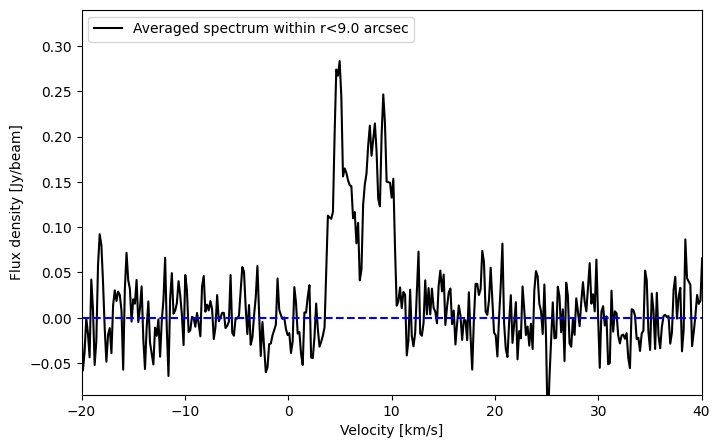

In [9]:
from casatasks import specflux
imname = myimages+'.pbcor'
splogf = imname+'.spec.log'
spradi = 9.0 # arcsec
specflux(imagename=imname,
         region = 'circle[[400pix,400pix],'+str(spradi)+'arcsec]', # in circle for field center
         function='flux density', unit='km/s',
         logfile = splogf, overwrite=True)
dt1_ax,dt1_npx,dt1_frq,dt1_vl,dt1_fl = np.loadtxt(splogf, comments='#', unpack=True)

imgview=1 # yaxis selection: 0=channel, 1=velocity
ymax = max(dt1_fl)
pltlab = "Averaged spectrum within r<"+str(spradi)+" arcsec"
ff, aa = plt.subplots(1,1, figsize=(8,5))
if imgview == 0:
    xmin=0 ; xmax=476
    imr = aa.plot(dt1_ax, dt1_fl, "-", color="k", label=pltlab)
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Channel")
elif imgview == 1:
    xmin=-20. ; xmax=40.
    imr = aa.plot(dt1_vl, dt1_fl, "-", color="k", label=pltlab)
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Velocity [km/s]")
aa.set_ylim(ymax*-0.3, ymax*1.2) ; aa.set_ylabel("Flux density [Jy/beam]")
plt.hlines([0], xmin, xmax, "blue", linestyles='dashed')
aa.legend(loc="upper left")
plt.savefig('HL_Tau.line_ave_spectrum.png', bbox_inches="tight", pad_inches=0.05)

視野中心より半径9"の円形内の平均スペクトルです。ダブルピークの輝線が検出されていることが分かります。
横軸についてはスクリプト中の"imgview"を変更すると、チャンネル(imgview=0)か速度(imgview=1)を選択できます。
ラインのある範囲とない範囲、ラインの中心速度（システム速度(原始星系の速度)と同等と予測される）がどのあたりになるかに注意してください。

### イメージRMS（及び輝線ピーク）を確認

In [10]:
from casatasks import imstat
imname = myimages+'.pbcor'
ctx=400 ; cty=400 # center pixs
stats1=imstat(imagename=imname,
          region='circle[['+str(ctx)+'pix,'+str(cty)+'pix],9.0arcsec],range=[30pix,180pix]')
stats2=imstat(imagename=imname,
          region='circle[['+str(ctx)+'pix,'+str(cty)+'pix],9.0arcsec],range=[300pix,450pix]')
imgrms=(stats1['rms'][0]+stats2['rms'][0])/2
print(f'RMS [mJy/beam] of {imname} : {imgrms*1000:.7f}')
stats3=imstat(imagename=imname,
          region='circle[['+str(ctx)+'pix,'+str(cty)+'pix],4.5arcsec],range=[200pix,280pix]')
imgmax=stats3['max'][0]
print(f'Max [mJy/beam] of {imname} : {imgmax*1000:.7f}')

RMS [mJy/beam] of HL_Tau.H2CO.cube.pbcor : 1.8930310
Max [mJy/beam] of HL_Tau.H2CO.cube.pbcor : 53.1570651


タスクimstatで、パラメータregionで指定された範囲内のイメージRMSやピーク値などの統計量を計算しています。<br>
領域"region"として、"circle"で視野中心（(x,y)=(400pix,400pix)）から半径9"(RMS)または半径4.5"(Max)の円形領域を、"range"で速度(周波数)方向の範囲をピクセルで指定しています。<br>

イメージRMS（ノイズの大きさ）を測るときは、天体からの放射のない領域で測定する様にします。
上記では、"range"で輝線の検出されていない周波数チャンネルを指定してRMSを求めています。<br>

regionの指定方法については、詳しくは以下をご覧ください。
<p style="padding-left:2em">
CASA Docs : <a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Region-File-Format" target="_blank" rel="noopener">Region File Format</a>
</p>

### モーメントマップ作成

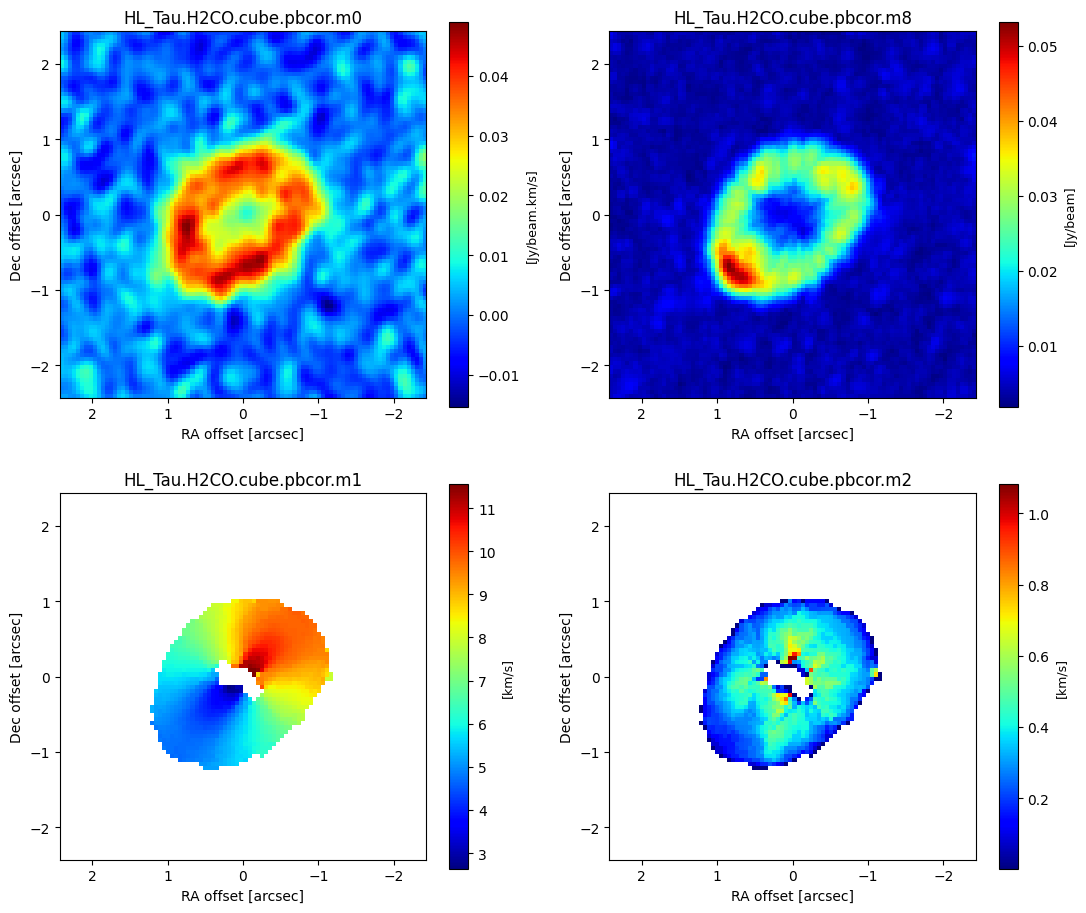

In [11]:
from casatasks import immoments
from casatasks import exportfits
imname = myimages+'.pbcor'
imname_m0 = imname+'.m0'
imname_m1 = imname+'.m1'
imname_m2 = imname+'.m2'
imname_m8 = imname+'.m8'
imname_lt = [imname_m0, imname_m8, imname_m1, imname_m2]
ctx=402 ; cty=391 ; mwd=180 # center pixs & image size
cutrms = 5.0        # intensity cut off for moment1 & moment2
mochs = [200, 280]  # channel ranges for moment maps
os.system('rm -rf '+imname+'.m*')
# moment0 & moment8
immoments(imagename = imname, outfile = imname_m0, moments = 0,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
immoments(imagename = imname, outfile = imname_m8, moments = 8,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
# moment1 & moment2
immoments(imagename = imname, outfile = imname_m1, moments = 1,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.],
       region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
immoments(imagename = imname, outfile = imname_m2, moments = 2,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.],
       region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
# fits
for name in imname_lt:
    exportfits(imagename=name, fitsimage=name+'.fits',
               dropstokes=True, overwrite=True)

ftdata = fits.open(imname_m0+'.fits')
ft_hdr = ftdata[0].header
ftdata.close()
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])

ft_hdr['CRVAL1'] = 0.0                   ; ft_hdr['CRVAL2'] = 0.0
ft_hdr['CRPIX1'] = mwd/2+1               ; ft_hdr['CRPIX2'] = mwd/2+1
ft_hdr['CDELT1'] = ft_hdr['CDELT1']*3600 ; ft_hdr['CDELT2'] = ft_hdr['CDELT2']*3600

blcx=int(ft_hdr['CRPIX1']-mwd/4) ; trcx=int(ft_hdr['CRPIX1']+mwd/4)
blcy=int(ft_hdr['CRPIX2']-mwd/4) ; trcy=int(ft_hdr['CRPIX2']+mwd/4)
#print(blcx,trcx,blcy,trcy,'/',mwd)

ofx_st=(ft_hdr['CRVAL1']+( blcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+( trcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+( blcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+( trcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st,ofx_ed,ofy_st,ofy_ed)

unit_lt = ["["+ft_hdr['BUNIT']+"]", "[Jy/beam]", "[km/s]", "[km/s]"]

ff, aa = plt.subplots(2,2, figsize=(13,11))
for ii, name in enumerate(imname_lt):
    xx,yy = int(ii/2),ii%2
    im = aa[xx,yy].imshow(fits.getdata(name+'.fits')[0,blcx:trcx,blcy:trcy],
                          extent=(ofx_st,ofx_ed,ofy_st,ofy_ed), origin='lower', cmap='jet')
    cbar=plt.colorbar(im, ax=aa[xx,yy])
    cbar.set_label(unit_lt[ii],size=9)
    aa[xx,yy].set_title(name)
    aa[xx,yy].set_xlim(ofx_st,ofx_ed) ; aa[xx,yy].set_ylim(ofy_st,ofy_ed)
    aa[xx,yy].set_xlabel("RA offset [arcsec]") ; aa[xx,yy].set_ylabel("Dec offset [arcsec]")
plt.savefig('HL_Tau.line_moment_maps.png', bbox_inches="tight", pad_inches=0.05)

スペクトル線データから作成されるイメージは、2つの空間軸と1つの周波数(又は速度)軸の3次元のイメージキューブになり、これらの3つのイメージ平面を操作してモーメントマップが作成できます。<br>
ここで作成したモーメントマップは、moment 0は積分強度マップ、moment 1は速度場マップ、moment 2は速度分散マップ、moment 8はピーク強度マップになります。<br>

モーメントマップについては、詳しくは以下を参考にして下さい。
- CASA Docs :
<a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Spectral-Analysis" target="_blank" rel="noopener">Spectral Analysis</a>
- CASA Toolkit Reference Manual :
<a href="https://casa.nrao.edu/docs/CasaRef/image.moments.html" target="_blank" rel="noopener">Compute moments from an image</a>

なお、ここではモーメントマップを作成する際、円盤の中心付近（中心位置を(x,y)=(402pix,391pix)とする）の領域のみを切り出しています。
また、モーメント1及びモーメント2マップについてはノイズの影響を避けるため5 &#x3C3;以上のみのデータを使って作成しています。

### 連続波イメージとの比較

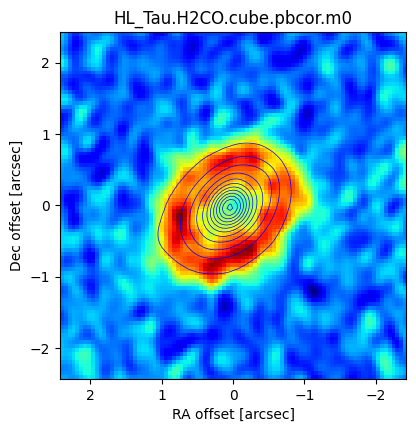

In [12]:
from casatasks import importfits
from casatasks import imsubimage
from casatasks import exportfits
from casatasks import imstat
imname2 = myimages2+'.pbcor'
is_file = os.path.exists(imname2)
if not is_file:
    importfits(fitsimage=orgimfits2,
               imagename=imname2, overwrite=True)
imname2_sub = imname2+'.zoom_tmp'
ctx=402 ; cty=391 ; mwd=180 # center pixs & image size (the same as that in the previous step)
os.system('rm -rf '+imname2_sub+'*')
imsubimage(imagename=imname2,
      outfile=imname2_sub,
      region='centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
exportfits(imagename=imname2_sub, fitsimage=imname2_sub+'.fits',
      dropstokes=True, overwrite=True)
stats1=imstat(imagename=imname2,
      region='annulus[['+str(ctx)+'pix,'+str(cty)+'pix],[4.5arcsec,14.0arcsec]]')
imgrms=stats1['rms'][0]
thrd = imgrms*5.
cinc = imgrms*25.
levels=[thrd,thrd+cinc*1.0,thrd+cinc*2.0,thrd+cinc*3.0,thrd+cinc*4.0,thrd+cinc*5.0,
        thrd+cinc*6.0,thrd+cinc*7.0,thrd+cinc*8.0,thrd+cinc*9.0,thrd+cinc*10.0,
        thrd+cinc*11.0,thrd+cinc*12.0,thrd+cinc*13.0,thrd+cinc*14.0,thrd+cinc*15.0]
colors = 'blue'

imname = myimages+'.pbcor'
imname_m0 = imname+'.m0'
ftdata = fits.open(imname_m0+'.fits')
ft_hdr = ftdata[0].header
ftdata.close()

ft_hdr['CRVAL1'] = 0.0                   ; ft_hdr['CRVAL2'] = 0.0
ft_hdr['CRPIX1'] = mwd/2+1               ; ft_hdr['CRPIX2'] = mwd/2+1
ft_hdr['CDELT1'] = ft_hdr['CDELT1']*3600 ; ft_hdr['CDELT2'] = ft_hdr['CDELT2']*3600

blcx=int(ft_hdr['CRPIX1']-mwd/4) ; trcx=int(ft_hdr['CRPIX1']+mwd/4)
blcy=int(ft_hdr['CRPIX2']-mwd/4) ; trcy=int(ft_hdr['CRPIX2']+mwd/4)
#print(blcx,trcx,blcy,trcy,'/',mwd)

ofx_st=(ft_hdr['CRVAL1']+( blcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+( trcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+( blcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+( trcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st,ofx_ed,ofy_st,ofy_ed)

# raster image for line moment0
ff, aa = plt.subplots(1,1, figsize=(8,4.5))
imr = aa.imshow(fits.getdata(imname_m0+'.fits')[0,blcx:trcx,blcy:trcy],
                extent=(ofx_st,ofx_ed,ofy_st,ofy_ed), origin='lower', cmap='jet')
aa.set_title(imname_m0)
aa.set_xlim(ofx_st,ofx_ed) ; aa.set_ylim(ofy_st,ofy_ed)
aa.set_xlabel("RA offset [arcsec]") ; aa.set_ylabel("Dec offset [arcsec]")
# contour image for cintinuum
fits_img = fits.getdata(imname2_sub+'.fits')[0,blcx:trcx,blcy:trcy]
xcont = np.arange(ofx_st, ofx_ed, (ofx_ed - ofx_st)/(ft_hdr['NAXIS1']/2-1) )
ycont = np.arange(ofy_st, ofy_ed, (ofy_ed - ofy_st)/(ft_hdr['NAXIS2']/2-1) )
imc = aa.contour(xcont, ycont, fits_img, colors=colors, levels=levels, linewidths=0.5)
plt.savefig('HL_Tau.linem0_cont_image.png', bbox_inches="tight", pad_inches=0.05)

モーメント0マップ（カラー）に連続波イメージをコントア（一番低いコントアのレベルは5 &#x3C3;）で重ねた図です。この図より、ダスト円盤とガス円盤の位置が良く一致していることが分かります。<br>
連続波イメージは「連続波イメージよりダスト円盤の物理量を導出する」で使用したイメージと同じデータを使用します。連続波イメージについての詳細はそちらをご覧ください。

### ガス円盤の見た目の位置角の推定

Gas disk PA (position angle) = 134.53344 deg


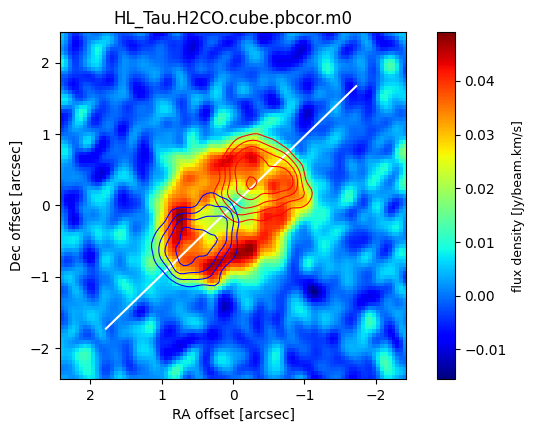

In [13]:
from casatasks import immoments
from casatasks import exportfits
imname = myimages+'.pbcor'
imname_m0 = imname+'.m0'
imname_m0a = imname+'.m0_red'
imname_m0b = imname+'.m0_blue'
imname_lt = [imname_m0a, imname_m0b]
ctx=402 ; cty=391 ; mwd=180 # center pixs & image size (the same as that in the previous step)
sysch=243 # channel of system velocity
offch=13  # offset channel for red/blue shift components
os.system('rm -rf '+imname+'.m0_red '+imname+'.m0_blue')
immoments(imagename = imname, outfile = imname_m0a,
      axis = 'spectral', moments = 0, chans = '200~'+str(sysch-offch),
      region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
immoments(imagename = imname, outfile = imname_m0b,
      axis = 'spectral', moments = 0, chans = str(sysch+offch)+'~280',
      region = 'centerbox[['+str(ctx)+'pix,'+str(cty)+'pix],['+str(mwd)+'pix,'+str(mwd)+'pix]]')
for name in imname_lt:
    exportfits(imagename=name, fitsimage=name+'.fits',
               velocity=True, dropstokes=True, overwrite=True)

from casatasks import imfit
xfit_A_res = imfit(imname_m0a,
               region = 'circle[['+str(int(mwd/2))+'pix,'+str(int(mwd/2))+'pix],1.5arcsec]',
               newestimates = imname_m0a+'.imfit_estimates',
               logfile = imname_m0a+'.imfit_log')
xfit_B_res = imfit(imname_m0b,
               region = 'circle[['+str(int(mwd/2))+'pix,'+str(int(mwd/2))+'pix],1.5arcsec]',
               newestimates = imname_m0b+'.imfit_estimates',
               logfile = imname_m0b+'.imfit_log')
xfit_A = xfit_A_res['results']['component0']
xfit_B = xfit_B_res['results']['component0']

from casatasks import imhead
imhd_A_res = imhead(imname_m0a)
incrx = abs(math.degrees(imhd_A_res['incr'][0])*3600)
incry = abs(math.degrees(imhd_A_res['incr'][1])*3600)
dxx = xfit_A['pixelcoords'][0]-xfit_B['pixelcoords'][0]
dyy = xfit_A['pixelcoords'][1]-xfit_B['pixelcoords'][1]

# tan(a)=sin(b)tan(A)
gdkpa =  90. + math.degrees(math.atan2( math.sin(math.radians(dxx*incrx)), math.tan(math.radians(dyy*incry)) ))
print(f'Gas disk PA (position angle) = {gdkpa:.5f} deg')

ftdata = fits.open(imname_m0+'.fits')
ft_hdr = ftdata[0].header
ftdata.close()
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])

ft_hdr['CRVAL1'] = 0.0                   ; ft_hdr['CRVAL2'] = 0.0
ft_hdr['CRPIX1'] = mwd/2+1               ; ft_hdr['CRPIX2'] = mwd/2+1
ft_hdr['CDELT1'] = ft_hdr['CDELT1']*3600 ; ft_hdr['CDELT2'] = ft_hdr['CDELT2']*3600

blcx=int(ft_hdr['CRPIX1']-mwd/4) ; trcx=int(ft_hdr['CRPIX1']+mwd/4)
blcy=int(ft_hdr['CRPIX2']-mwd/4) ; trcy=int(ft_hdr['CRPIX2']+mwd/4)
#print(blcx,trcx,blcy,trcy,'/',mwd)

ofx_st=(ft_hdr['CRVAL1']+( blcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+( trcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+( blcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+( trcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st,ofx_ed,ofy_st,ofy_ed)

blcx2=int(ft_hdr['CRPIX1'] - math.cos(math.radians(gdkpa-90.))*mwd/4)
trcx2=int(ft_hdr['CRPIX1'] + math.cos(math.radians(gdkpa-90.))*mwd/4)
blcy2=int(ft_hdr['CRPIX2'] - math.sin(math.radians(gdkpa-90.))*mwd/4)
trcy2=int(ft_hdr['CRPIX2'] + math.sin(math.radians(gdkpa-90.))*mwd/4)
#print(blcx2,trcx2,blcy2,trcy2,'/',mwd)

ofx_st2=(ft_hdr['CRVAL1']+( blcx2 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed2=(ft_hdr['CRVAL1']+( trcx2 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st2=(ft_hdr['CRVAL2']+( blcy2 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed2=(ft_hdr['CRVAL2']+( trcy2 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
#print(ofx_st2,ofx_ed2,ofy_st2,ofy_ed2)

from casatasks import imstat
stats1=imstat(imagename=imname_m0,
          region='annulus[['+str(int(mwd/2))+'pix,'+str(int(mwd/2))+'pix],[40pix,150pix]]')
imgrms=stats1['rms'][0]
thrd = imgrms*2.
levels = [thrd*1.0,thrd*2.0,thrd*3.0,thrd*4.0,thrd*5.0]
colors = ['red','blue']

ff, aa = plt.subplots(1,1, figsize=(8,4.5))
imr = aa.imshow(fits.getdata(imname_m0+'.fits')[0,blcx:trcx,blcy:trcy],
                extent=(ofx_st,ofx_ed,ofy_st,ofy_ed), origin='lower', cmap='jet')
aa.plot([ofx_st2,ofx_ed2], [ofy_st2,ofy_ed2], 'white')
cbar=plt.colorbar(imr, ax=aa)
cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
aa.set_title(imname_m0)
aa.set_xlim(ofx_st,ofx_ed) ; aa.set_ylim(ofy_st,ofy_ed)
aa.set_xlabel("RA offset [arcsec]") ; aa.set_ylabel("Dec offset [arcsec]")
for ii, name in enumerate(imname_lt):
    fits_img = fits.getdata(name+'.fits')[0,blcx:trcx,blcy:trcy]
    xcont = np.arange(ofx_st,ofx_ed, (ofx_ed-ofx_st)/(ft_hdr['NAXIS1']/2-1))
    ycont = np.arange(ofy_st,ofy_ed, (ofy_ed-ofy_st)/(ft_hdr['NAXIS2']/2-1))
    imc = aa.contour(xcont, ycont, fits_img, colors=colors[ii], levels=levels, linewidths=0.75)
plt.savefig('HL_Tau.line_red_blue_image.png', bbox_inches="tight", pad_inches=0.05)

赤方偏移成分と青方偏移成分について別々にモーメント0マップ(積分強度図)を作成し、2Dガウシアンフィットを行いそれぞれの中心位置のずれから長軸の位置角PA（Position Angle）を推定しています。
赤方/青方偏移成分については、システム速度(sysch)を中心にオフセット(offch)を取って、そのプラス側・マイナス側を赤方・青方偏移成分としてモーメントマップを作成しています。<br>
また、前述の全速度範囲のモーメント0マップをカラーで、ここで作成した赤方/青方偏移成分のモーメント0マップをコントアで重ねたイメージを作成しています。
長軸方向に円盤の両側で、右上が赤方偏移成分(システム速度からプラス速度側)、左下が青方偏移成分(システム速度からマイナス速度側)が分布していることが分かります。この事から、円盤が短軸方向に近い軸を中心に回転運動をしていることが推測できます。<br>
なお、図中の白直線は円盤の長軸方向を表します（円盤中心(視野中心)と位置角PAから予測される）。後述の位置速度図(PVマップ)はこの直線方向及び垂直方向に切って速度方向の強度分布を求めたものです。

### PVマップ(位置速度図)作成

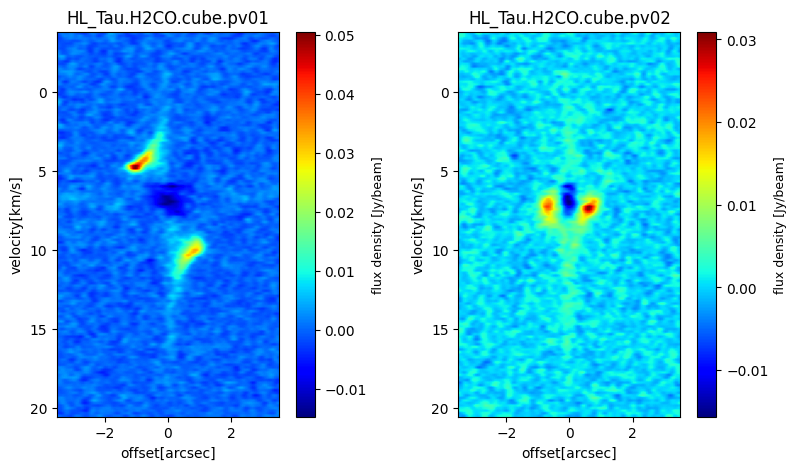

In [14]:
from casatasks import impv
from casatasks import exportfits
imname = myimages+'.pbcor'
pvname1 = myimages+'.pv01'
pvname2 = myimages+'.pv02'
pvname_lt = [pvname1, pvname2]
ctx=402 ; cty=391 # center pixs
pvpa  = gdkpa # PA (deg)
pleng = 7.0 # arcsec
vlrag = '160~310' # vel.ch.range [ch]
os.system('rm -rf '+pvname1+'*')
impv(imagename = imname, outfile = pvname1,
     mode = 'length', center = [ctx, cty],
     length = str(pleng)+'arcsec', pa = str(pvpa)+'deg',
     width = 5, chans = vlrag)
os.system('rm -rf '+pvname2+'*')
impv(imagename = imname, outfile = pvname2,
     mode = 'length', center = [ctx, cty],
     length = str(pleng)+'arcsec', pa = str(pvpa+90.)+'deg',
     width = 5, chans = vlrag)
for name in pvname_lt:
    exportfits(imagename=name, fitsimage=name+'.fits',
               velocity=True, dropstokes=True, overwrite=True)

ftdat = fits.open(pvname1+'.fits')
ft_hdr = ftdat[0].header
ftdat.close()
#print(ft_hdr['NAXIS1'],ft_hdr['CRPIX1'],ft_hdr['CRVAL1'],ft_hdr['CDELT1'],ft_hdr['CUNIT1'])
ofs_st=(ft_hdr['CRVAL1']+(              1 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofs_ed=(ft_hdr['CRVAL1']+(ft_hdr['NAXIS1']-ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
vel_st=(ft_hdr['CRVAL2']+(              1 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000
vel_ed=(ft_hdr['CRVAL2']+(ft_hdr['NAXIS2']-ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000
#print(ofs_st,ofs_ed,vel_st,vel_ed)

ff, aa = plt.subplots(1,2, figsize=(9.5,5))
for ii, name in enumerate(pvname_lt):
    xx = ii%2
    im = aa[xx].imshow(fits.getdata(name+'.fits'), extent=(ofs_st,ofs_ed,vel_st,vel_ed),
                       origin='lower', cmap='jet')
    aa[xx].set_xlabel("offset[arcsec]") ; aa[xx].set_xlim(ofs_st,ofs_ed)
    aa[xx].set_ylabel("velocity[km/s]") ; aa[xx].set_ylim(vel_st,vel_ed)
    aa[xx].set_aspect(0.5)
    cbar=plt.colorbar(im, ax=aa[xx])
    cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
    aa[xx].set_title(name)
plt.savefig('HL_Tau.line_pv_maps.png', bbox_inches="tight", pad_inches=0.05)

円盤の中心を基準に長軸・短軸の方向にカットした位置速度図(Position-Velocity map)です。
横軸が位置(オフセット)、縦軸が速度になります。位置速度図作成の際、円盤中心位置と位置角を指定しています。
これらの図よりガス円盤のダイナミクスが分かります。<br>
ケプラー回転を仮定すると、予想される回転曲線は以下の様に計算されてPV図上に表示できます。

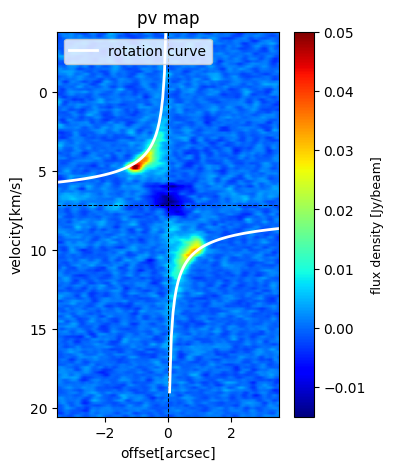

In [15]:
au  = 1.49597870700*10**(11) # m/AU
pc  = 3.085677581*10**(16)   # m/pc
Msol= 1.98847*10**(33)       # g        Solar mass
Grv = 6.67430*10**(-14)      # m3/g s2  Newtonian Constant of Gravitation

# for HL Tau
dist = 140.  # pc
stmass = 1.3 # Mo
Vsys = 7.2   # km/s
incl= 42.5   # deg

pvname = myimages+'.pv01'
ftdat = fits.open(pvname+'.fits')
ft_img = ftdat[0].data
ft_hdr = ftdat[0].header
ftdat.close()

NN = int(ft_hdr['NAXIS1']/2.)
dt_rx1 = [[] for _ in range(NN)] ; dt_rx2 = [[] for _ in range(NN)]
dt_vt1 = [[] for _ in range(NN)] ; dt_vt2 = [[] for _ in range(NN)]
for rrr in list(range(NN)):
    rrr += 1
    radu = dist*pc*math.tan(math.radians(rrr*ft_hdr['CDELT1']/3600))/2 # m
    dt_rx1[rrr-1] = -rrr*ft_hdr['CDELT1'] # arcsec
    dt_rx2[rrr-1] =  rrr*ft_hdr['CDELT1']
    dt_vt1[rrr-1] = Vsys - math.sqrt(Grv*(stmass*Msol)/radu)/1000 * math.cos(math.radians(90.-incl)) # km/s
    dt_vt2[rrr-1] = Vsys + math.sqrt(Grv*(stmass*Msol)/radu)/1000 * math.cos(math.radians(90.-incl))

ofs_st=(ft_hdr['CRVAL1']+(              1 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofs_ed=(ft_hdr['CRVAL1']+(ft_hdr['NAXIS1']-ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
vel_st=(ft_hdr['CRVAL2']+(              1 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000
vel_ed=(ft_hdr['CRVAL2']+(ft_hdr['NAXIS2']-ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000

ff, aa = plt.subplots(1,1, figsize=(4,5))
img = aa.imshow(ft_img, origin='lower', extent=(ofs_st,ofs_ed,vel_st,vel_ed),
                vmin=-0.015, vmax=0.05, cmap='jet')
aa.set_xlabel("offset[arcsec]") ; aa.set_xlim(ofs_st,ofs_ed)
aa.set_ylabel("velocity[km/s]") ; aa.set_ylim(vel_st,vel_ed)
aa.set_aspect(0.5)
cbar=plt.colorbar(img, ax=aa)
cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
aa.set_title('pv map')
plt.vlines(   [0], vel_st, vel_ed, "black", linewidth = 0.7, linestyles='dashed')
plt.hlines([Vsys], ofs_st, ofs_ed, "black", linewidth = 0.7, linestyles='dashed')
imr = aa.plot(dt_rx1, dt_vt1, "-", color='white', linewidth = 2.0, label="rotation curve")
imr = aa.plot(dt_rx2, dt_vt2, "-", color='white', linewidth = 2.0)
aa.legend(loc="upper left")
plt.savefig('HL_Tau.line_pvmap_model.png', bbox_inches="tight", pad_inches=0.05)

ケプラー回転する薄く軸対称なガス円盤を考えると、中心から半径$r$の回転速度は $V_{\rm rot}=\sqrt{GM/r}$ と表せます。
また、ガス円盤の傾き(face onより)を$incl$とすると、回転速度$V_{\rm rot}$の視線方向の成分は $V_{\rm los}=V_{\rm rot}\cos(90-incl)$ になります。この視線方向の速度成分がPV図上での速度に対応します。
なお、ここでは中心星の質量を1.3 Mo、星系のシステム速度を$V_{\rm sys}$=7.2 km/s、ガス円盤の傾きを$incl$=42.5 degと仮定しています。<br>
PV図上のフラックス分布は、ここで予想したケプラー回転の位置-速度プロファイルとよく一致している様に見えます。なお、図中の黒点線はシステム速度Vsysと中心からのオフセット０の位置を示しています。

In [16]:
print('END')

END
